In [300]:
! sudo apt update -y && sudo apt install -qq tesseract-ocr -y 

Hit:1 http://deb.debian.org/debian bullseye InRelease
Hit:2 http://deb.debian.org/debian-security bullseye-security InRelease
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Hit:4 https://dl.yarnpkg.com/debian stable InRelease                           
Fetched 44.1 kB in 0s (150 kB/s)                
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
6 packages can be upgraded. Run 'apt list --upgradable' to see them.
tesseract-ocr is already the newest version (4.1.1-2.1).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [301]:
! pip install pytesseract sentence-transformers nltk python-levenshtein matplotlib nlpaug seaborn --quiet

In [332]:
from datasets import load_dataset
from transformers import pipeline
from matplotlib import pyplot as plt
from sentence_transformers import datasets as sent_datasets
import Levenshtein
import pytesseract
import numpy as np
import seaborn as sns
import nlpaug.augmenter.char as nac
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [303]:
ocr_kwargs: dict = dict (
  name= "OCR_Aug",
  aug_char_min= 2,
  aug_char_max= 10 ,
  aug_char_p= .3 ,
  aug_word_p= .6,
  aug_word_min= 1,
  aug_word_max= 20,
  stopwords= None,
  tokenizer= None,
  reverse_tokenizer= None,
  verbose= 0,
  stopwords_regex= None,
  min_char= 1
)

In [304]:
sample = load_dataset("lowem1/cc_news_images", split="sample")

In [305]:
row = sample[-3]

In [306]:
def process_nlp_aug(batch, col, config):
    aug = nac.OcrAug(**config)
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = aug.augment(record)[0]
        output_records.append(transform)
    return dict(nlp_aug_text=output_records)
    
def process_ntlk_aug(batch, col):
    noise_fn = sent_datasets.DenoisingAutoEncoderDataset([]).noise_fn
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = noise_fn(record)
        output_records.append(transform)
    return dict(tsdae_text=output_records)

def process_ocr_batch(batch, col, config="--psm 6"):
    input_records = batch[col]
    output_records = []
    for record in input_records:
        transform = pytesseract.image_to_string(image=record, config=config)
        output_records.append(transform)
    return dict(ocr_text=output_records)

def process_levenshtein_distance(batch, col1, col2, output_col=None):
    labels = batch[col1]
    output_records = []
    ocr = batch[col2]
    for s1, s2 in zip(labels, ocr):
        s1 = s1.strip("\n")
        s2 = s2.strip("\n")
        distance = Levenshtein.distance(s1, s2)
        output_records.append(distance)
    return {
        output_col: output_records
    }

def process_cardinality_distance(batch, col1, col2, output_col=None):
    labels = batch[col1]
    output_records = []
    ocr = batch[col2]
    for s1, s2 in zip(labels, ocr):
        s1_tokens = np.sort(
            np.unique(
                np.array(" ".join(s1.split("\n")).split(" "))
            )
        )
        s2_tokens = np.sort(
            np.unique(
                np.array(" ".join(s2.split("\n")).split(" "))
            )
        )
        disjoint_score = len(set(s2) - set(s1))
        output_records.append(disjoint_score)
    return {
        output_col: output_records
    }


In [310]:
sample_set = sample

In [311]:

# transform_pipeline = (
#     s.select_columns(["image", "text"])
#     .map(
#         function=process_ocr_batch,
#         fn_kwargs=dict(col="image", config="psm --6"),
#         num_proc=16,
        
#         batched=True,
#         batch_size=8
#     )
# )

In [312]:
distances_report = (
    sample_set.map(
        function=process_ocr_batch,
        fn_kwargs=dict(col="image", config="--psm 6"),
        num_proc=16,
        batched=True,
        batch_size=8
    )
    .map(
        function=process_ntlk_aug,
        fn_kwargs=dict(col="text"),
        num_proc=8,
        batched=True,
        batch_size=16,
    )
    .map(
        function=process_nlp_aug,
        fn_kwargs=dict(col="text", config=ocr_kwargs),
        num_proc=8,
        batched=True,
        batch_size=16,
    )
    .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(col1="text", col2="ocr_text", output_col="comp_distance"),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(col1="text", col2="ocr_text", output_col="disjoint_score"),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(
            col1="text", col2="tsdae_text", output_col="tsdae_comp_distance"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(
            col1="text", col2="tsdae_text", output_col="tsdae_disjoint_score"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
        .map(
        function=process_levenshtein_distance,
        fn_kwargs=dict(
            col1="text", col2="nlp_aug_text", output_col="nlp_aug_comp_distance"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .map(
        function=process_cardinality_distance,
        fn_kwargs=dict(
            col1="text", col2="nlp_aug_text", output_col="nlp_aug_disjoint_score"
        ),
        num_proc=16,
        batched=True,
        batch_size=8,
    )
    .select_columns(
        [
            "text",
            "ocr_text",
            "nlp_aug_text",
            "tsdae_text",
            "comp_distance",
            "disjoint_score",
            "tsdae_comp_distance",
            "tsdae_disjoint_score",
            "nlp_aug_comp_distance",
            "nlp_aug_disjoint_score",
        ]
    )
)


Map (num_proc=16): 100%|██████████| 439/439 [00:00<00:00, 1914.71 examples/s]


<Axes: ylabel='Density'>

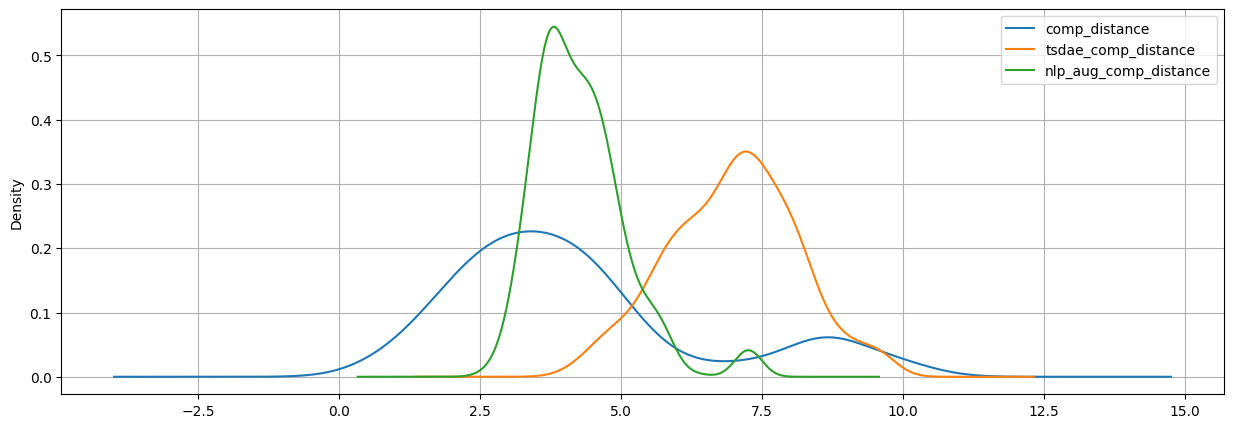

In [313]:
(
    distances_report
    .select_columns(["comp_distance", "tsdae_comp_distance", "nlp_aug_comp_distance"])
    .to_pandas()
    .apply(np.log)
    .plot
    .density(figsize=(15,5), grid=True)
)

<Axes: ylabel='Density'>

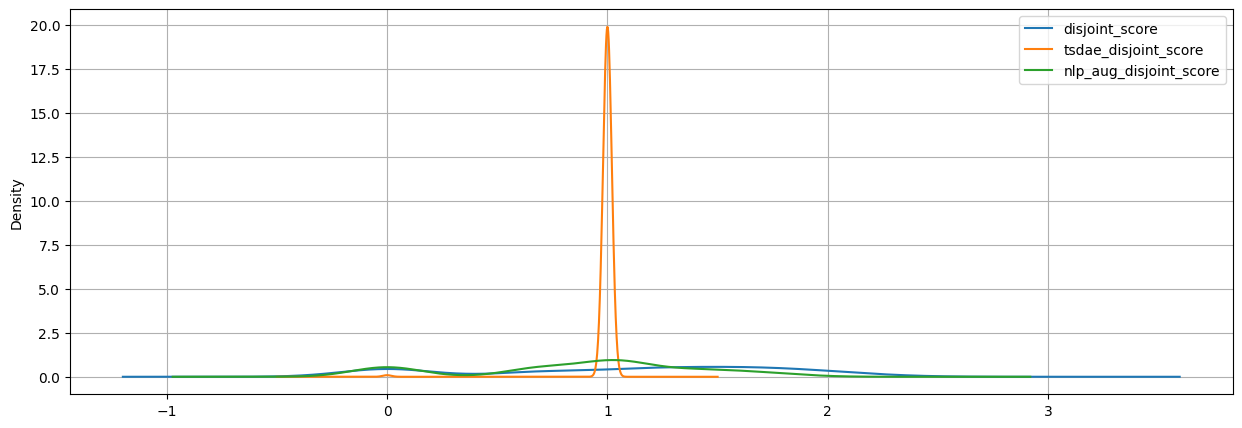

In [330]:
(
    distances_report
    .select_columns(["disjoint_score", "tsdae_disjoint_score", "nlp_aug_disjoint_score"])
    .to_pandas()
    .apply(np.log)
    .replace([np.inf, -np.inf], 1)
    .plot
    .density(figsize=(15,5), grid=True)
)

In [321]:
distances_report.select_columns(["comp_distance", "tsdae_comp_distance", "nlp_aug_comp_distance"]).to_pandas().describe()

,comp_distance,tsdae_comp_distance,nlp_aug_comp_distance
count,439.000000,439.000000,439.000000
mean,1320.391800,1997.264237,118.248292
std,3895.514974,2650.134793,219.469732
min,2.000000,60.000000,14.000000
25%,14.000000,478.500000,41.000000
50%,42.000000,1165.000000,64.000000
75%,131.500000,2399.500000,107.000000
max,23526.000000,14488.000000,1424.000000


In [322]:
distances_report.select_columns(["disjoint_score", "tsdae_disjoint_score", "nlp_aug_disjoint_score"], ).to_pandas().describe()

,disjoint_score,tsdae_disjoint_score,nlp_aug_disjoint_score
count,439.000000,439.000000,439.000000
mean,3.612756,0.004556,2.084282
std,2.211514,0.067420,1.739864
min,1.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000
50%,3.000000,0.000000,2.000000
75%,5.000000,0.000000,3.000000
max,11.000000,1.000000,7.000000
